### PTA 1p-function/statistics analysis-demo notebook

In this notebook, we present the computation of the one-point function statistics in PTA simulations; utilizing our `pulsar_op_stats` module. This is followed by an analysis of pre-computed one-point statistics samples in mock pulsar timing array (PTA) simulations with a gravitational wave background (GWB) and red noises (RN). See [arXiv:2407.17987](https://arxiv.org/abs/2407.17987) for more details.

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import json, os, glob, pickle

from pulsar_op_stats import *
from scipy.stats import norm # fitting gaussian to data

#### 0 Compute 1p-statistics using `pulsar_op_stats`

We demonstrate the computation of one-point statistics with PTA residuals using `pulsar_op_stats` master function `opstats_master`. A simple run is shown below:

In [2]:
if __name__ == "__main__":
    nsims=200 # number of realisations
    npsrs=50 # number of pulsars
    Tspan_yr=30 # observation time span in year
    ntoas=100 # number of toa measurements over Tspan_yr

    # GWB only; to add red noise add_red=True
    opstats_master(npsrs=npsrs, Tspan_yr=Tspan_yr, nsims=nsims, ntoas=ntoas, \
                   add_gwb=True, log10_A_gw=np.log10(2.4e-15), add_red=False)
    print(f'Done 1p-stats ({nsims} realizations) of {Tspan_yr} yr-fpta ({npsrs} MSPs) with GWB only.')

/home/reggie_apctp/miniconda3/envs/enterprise/lib/python3.10/site-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Done 1p-stats (200 realizations) of 30 yr-fpta (50 MSPs) with GWB only.


The computation is saved in the directory `/data`. The next sections show how to import this data can be used and interpreted.

#### 1 One-point statistics of a nanohertz GWB

We import the pre-computed one-point sample statistics obtained using the `pulsar_op_stats` and `fpta_opstats_master`. This is done as follow, given the number of pulsars and realisations:

In [3]:
# check dir for available samples
opstats_gwb_only=load_ensemble_stats(npsrs=100, nsims=5000, \
                                     gwb_binary=1, rn_binary=0, print_input=True)
opstats_rn_only=load_ensemble_stats(npsrs=100, nsims=5000, \
                                    gwb_binary=0, rn_binary=1, print_input=True)
# opstats_gwb_and_rn=load_ensemble_stats(npsrs=600, nsims=1000, \
#                                        gwb_binary=1, rn_binary=1, print_input=True)

{'npsrs': 100, 'Tspan_yr': 30, 'nsims': 5000, 'add_gwb': True, 'gamma_gw': 4.333333333333333, 'log10_A_gw': -14.619788758288394, 'add_red': False, 'add_white': False, 'n_bins': 14, 'ntoas': 100, 'toaerr': 1e-06}
{'npsrs': 100, 'Tspan_yr': 30, 'nsims': 5000, 'add_gwb': False, 'gamma_gw': 4.333333333333333, 'log10_A_gw': -19.619788758288394, 'add_red': True, 'add_white': False, 'n_bins': 14, 'ntoas': 100, 'toaerr': 1e-06}


Plot below shows the violin plot of the one-point statistics over frequencies;

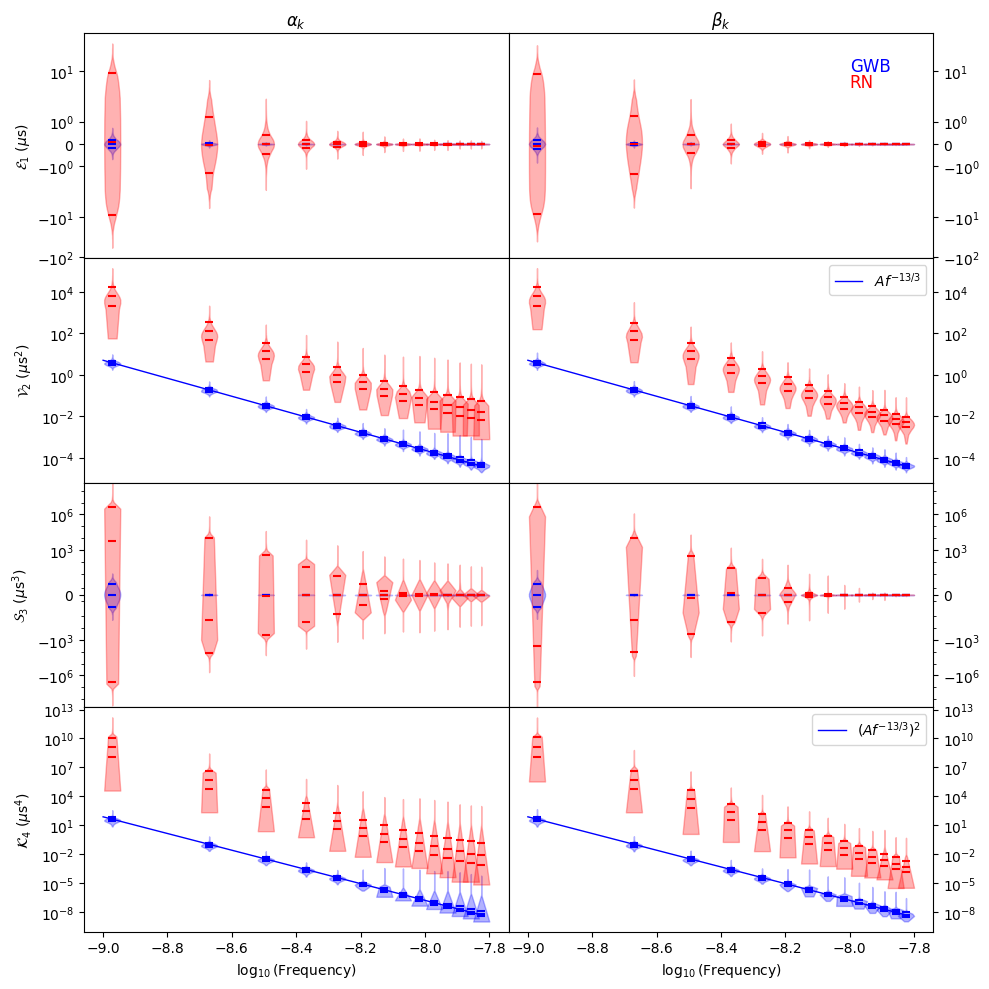

In [4]:
# violins
fig, ax=plt.subplots(nrows=4,ncols=2,sharex=True,sharey='row',figsize=(10,10))
plot_rk_moments(ax, opstats_gwb_only, color='blue', widths=0.05)
plot_rk_moments(ax, opstats_rn_only, color='red', widths=0.05)
# plot_rk_moments(ax, opstats_gwb_and_rn, color='green', widths=0.05)

f_cont=np.linspace(1,15, 100); logf_cont=np.log10(f_cont*1e-9)
gamma_gw=13/3; a_gw=5
pl_gw=lambda f: np.power(f,-gamma_gw)
ax[1,0].plot(logf_cont, a_gw*pl_gw(f_cont), 'b-', lw=1)
ax[1,1].plot(logf_cont, a_gw*pl_gw(f_cont), 'b-', lw=1, label=r'$A f^{-13/3}$')
ax[1,1].legend(loc='upper right')

# factor of 3, see paper 2407.17987
ax[3,0].plot(logf_cont, 3*(a_gw*pl_gw(f_cont))**2, 'b-', lw=1)
ax[3,1].plot(logf_cont, 3*(a_gw*pl_gw(f_cont))**2, 'b-', lw=1, label=r'$(A f^{-13/3})^2$')
ax[3,1].legend(loc='upper right')

ax[0,1].text(-8.0, 10, 'GWB', color='blue', fontsize=12)
ax[0,1].text(-8.0, 4, 'RN', color='red', fontsize=12)
    
ax[0,0].set_ylabel(r'${\cal E}_1$ ($\mu$s)')
ax[1,0].set_ylabel(r'${\cal V}_2$ ($\mu$s$^2$)')
ax[2,0].set_ylabel(r'${\cal S}_3$ ($\mu$s$^3$)')
ax[3,0].set_ylabel(r'${\cal K}_4$ ($\mu$s$^4$)')
ax[0,0].set_title(r'$\alpha_{k}$'); ax[0,1].set_title(r'$\beta_{k}$')
ax[len(ax)-1,0].set_xlabel(r'$\log_{10}$(Frequency)')
ax[len(ax)-1,1].set_xlabel(r'$\log_{10}$(Frequency)')

# ticks to right for the right column plots
for row in range(len(ax)):
    ax[row, 1].yaxis.tick_right()
    ax[row, 1].tick_params(labelright=True, labelleft=False)

ax[0,0].set_yscale('symlog'); ax[0,1].set_yscale('symlog')
ax[1,0].set_yscale('log'); ax[1,1].set_yscale('log')
ax[2,0].set_yscale('symlog'); ax[2,1].set_yscale('symlog')
ax[3,0].set_yscale('log'); ax[3,1].set_yscale('log')

ax[2,0].set_yticks([-1e6, -1e3, 0, 1e3, 1e6]); ax[2,1].set_yticks([-1e6, -1e3, 0, 1e3, 1e6])

fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)
plt.show()

This shows the GWB following the power spectrum and that the kurtosis presents a frequency relation consistent with it following a Gaussian GWB. On the other hand, it is shown that the RN component completely dominantes the one-point statistics.

The following looks at the 1st frequency bin and plots the distribution of the sample skewness in a histogram; in addition, the p-values are computed relative to a null hypothesis that the samples are drawn from a Gaussian distribution ($p$-values$\ll$0.05 indicates non-Gaussianity).

gwb
p_vals ak [2.43483841e-034 1.13426457e-132 1.00000000e-004]
p_vals bk [1.45166113e-039 6.19053118e-147 1.00000000e-004]

rn
p_vals ak [0.     0.     0.0001]
p_vals bk [0.     0.     0.0001]



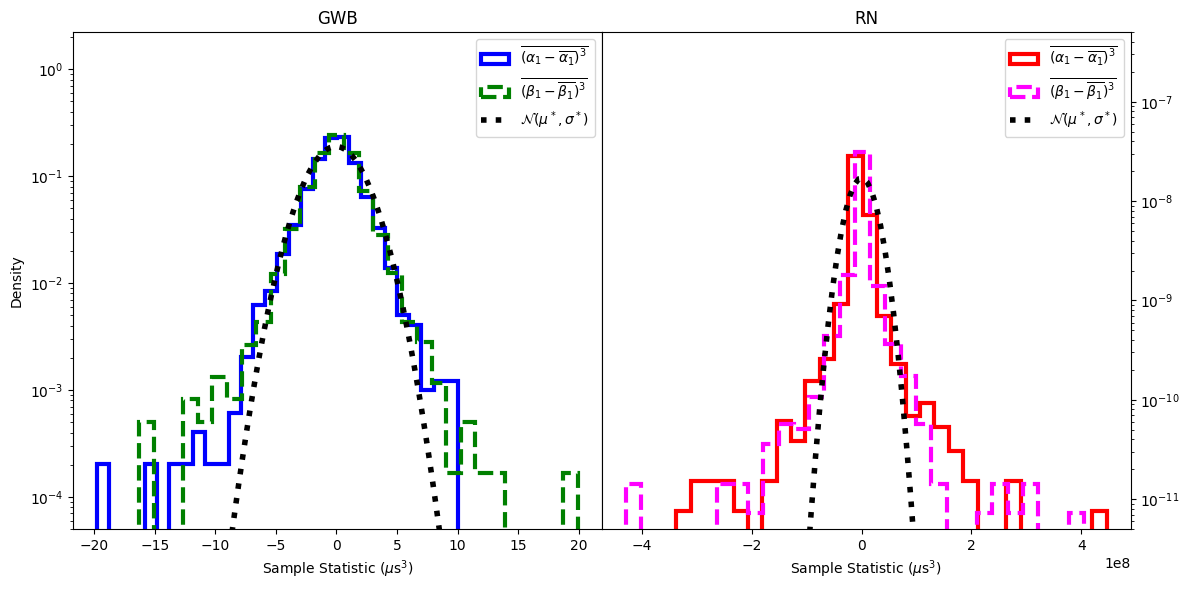

In [5]:
bin_index=0 # frequency bin, 0=first bin, 1=so on
st_index=2 # st_index=0 (mean), 1 (variance), 2 (skewness), 3 (kurtosis)
res_units=1e-6

# print pvals
print('gwb')
print('p_vals ak', get_pvals(opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))))
print('p_vals bk', get_pvals(opstats_gwb_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1))))
print()

print('rn')
print('p_vals ak', get_pvals(opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))))
print('p_vals bk', get_pvals(opstats_rn_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1))))
print()

fig,ax=plt.subplots(ncols=2,figsize=(12,6))
ax[0].hist(opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='blue', histtype='step', density=True, ls='-', lw=3, \
           label=rf'$ \overline{{ (\alpha_{{{bin_index+1}}} - \overline{{\alpha_{{{bin_index+1}}} }} )^{st_index+1} }} $')
ax[0].hist(opstats_gwb_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='green', histtype='step', density=True, ls='--', lw=3, \
           label=rf'$ \overline{{ (\beta_{{{bin_index+1}}} - \overline{{\beta_{{{bin_index+1}}} }} )^{st_index+1} }} $')
# gaussian fit to data
data=opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p = norm.pdf(x, mu, std)
ax[0].plot(x, p, 'k:', lw=4, label=r'${\cal N}(\mu^*, \sigma^*)$')
ax[0].set_yscale('log')
ax[0].set_xlabel(rf'Sample Statistic ($\mu$s$^{st_index+1}$)')
ax[0].set_ylabel('Density')
ax[0].legend(loc='upper right')
ax[0].set_title('GWB')

ax[1].hist(opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='red', histtype='step', density=True, ls='-', lw=3, \
           label=rf'$ \overline{{ (\alpha_{{{bin_index+1}}} - \overline{{\alpha_{{{bin_index+1}}} }} )^{st_index+1} }} $')
ax[1].hist(opstats_rn_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='magenta', histtype='step', density=True, ls='--', lw=3, \
           label=rf'$ \overline{{ (\beta_{{{bin_index+1}}} - \overline{{\beta_{{{bin_index+1}}} }} )^{st_index+1} }} $')
# gaussian fit to data
data=opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p = norm.pdf(x, mu, std)
ax[1].plot(x, p, 'k:', lw=4, label=r'${\cal N}(\mu^*, \sigma^*)$')
ax[1].set_yscale('log')
ax[1].set_xlabel(rf'Sample Statistic ($\mu$s$^{st_index+1}$)')
ax[1].legend(loc='upper right')
ax[1].set_title('RN')

ax[0].set_ylim(bottom=5e-5)
ax[1].set_ylim(bottom=5e-12, top=5e-7)

ax[1].yaxis.tick_right()
fig.tight_layout()
fig.subplots_adjust(wspace=0)
plt.show()

This indicates that the distribution of the sample skewness for the GWB and the RN components are non-Gaussian. This for the different reasons as explained in [arXiv:2407.17987](https://arxiv.org/abs/2407.17987); for GWB, the quadrupolar correlation sources non-Gaussianity, for RN, the variation in the spectrum across pulsars. 

The following prints out the analogous computation for the distribution of the sample kurtosis.

gwb
p_vals ak [0.     0.     0.0001]
p_vals bk [0.     0.     0.0001]

rn
p_vals ak [0.     0.     0.0001]
p_vals bk [0.     0.     0.0001]



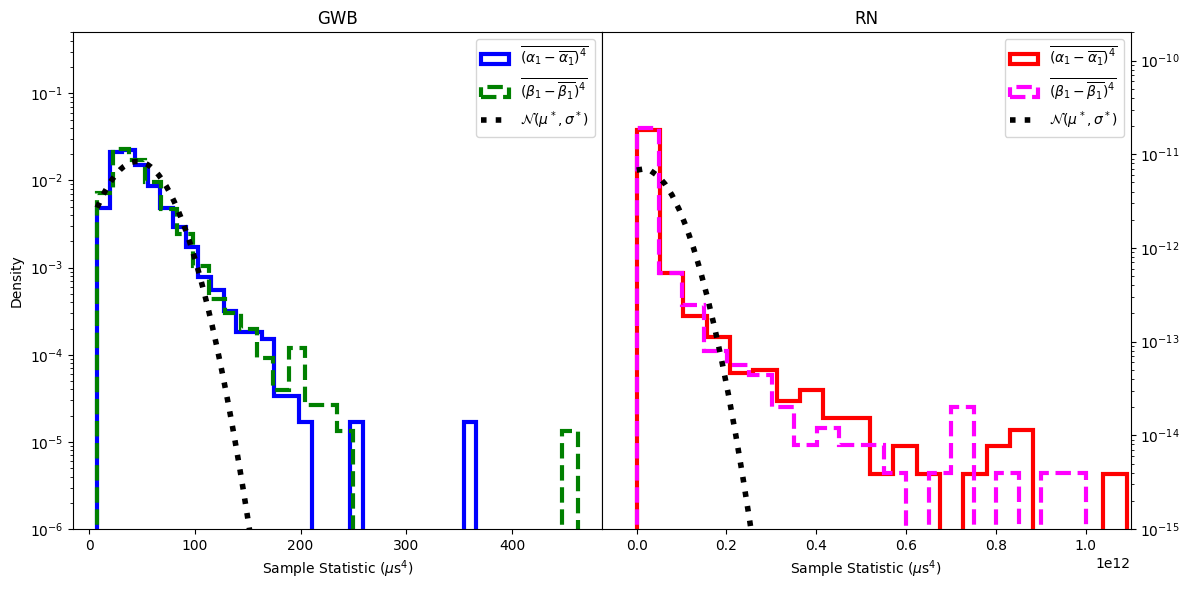

In [6]:
bin_index=0 # frequency bin, 0=first bin, 1=so on
st_index=3 # st_index=0 (mean), 1 (variance), 2 (skewness), 3 (kurtosis)
res_units=1e-6

# print pvals
print('gwb')
print('p_vals ak', get_pvals(opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))))
print('p_vals bk', get_pvals(opstats_gwb_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1))))
print()

print('rn')
print('p_vals ak', get_pvals(opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))))
print('p_vals bk', get_pvals(opstats_rn_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1))))
print()


fig,ax=plt.subplots(ncols=2,figsize=(12,6))
ax[0].hist(opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='blue', histtype='step', density=True, ls='-', lw=3, \
           label=rf'$ \overline{{ (\alpha_{{{bin_index+1}}} - \overline{{\alpha_{{{bin_index+1}}} }} )^{st_index+1} }} $')
ax[0].hist(opstats_gwb_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='green', histtype='step', density=True, ls='--', lw=3, \
           label=rf'$ \overline{{ (\beta_{{{bin_index+1}}} - \overline{{\beta_{{{bin_index+1}}} }} )^{st_index+1} }} $')
# gaussian fit to data
data=opstats_gwb_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p = norm.pdf(x, mu, std)
ax[0].plot(x, p, 'k:', lw=4, label=r'${\cal N}(\mu^*, \sigma^*)$')
ax[0].set_yscale('log')
ax[0].set_xlabel(rf'Sample Statistic ($\mu$s$^{st_index+1}$)')
ax[0].set_ylabel('Density')
ax[0].legend(loc='upper right')
ax[0].set_title('GWB')

ax[1].hist(opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='red', histtype='step', density=True, ls='-', lw=3, \
           label=rf'$ \overline{{ (\alpha_{{{bin_index+1}}} - \overline{{\alpha_{{{bin_index+1}}} }} )^{st_index+1} }} $')
ax[1].hist(opstats_rn_only['rk_stats']['bk'][:,bin_index,st_index]/(res_units**(st_index+1)), bins=30, \
           color='magenta', histtype='step', density=True, ls='--', lw=3, \
           label=rf'$ \overline{{ (\beta_{{{bin_index+1}}} - \overline{{\beta_{{{bin_index+1}}} }} )^{st_index+1} }} $')
# gaussian fit to data
data=opstats_rn_only['rk_stats']['ak'][:,bin_index,st_index]/(res_units**(st_index+1))
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p = norm.pdf(x, mu, std)
ax[1].plot(x, p, 'k:', lw=4, label=r'${\cal N}(\mu^*, \sigma^*)$')
ax[1].set_yscale('log')
ax[1].set_xlabel(rf'Sample Statistic ($\mu$s$^{st_index+1}$)')
ax[1].legend(loc='upper right')
ax[1].set_title('RN')

ax[0].set_ylim(bottom=1e-6, top=5e-1)
ax[1].set_ylim(bottom=1e-15, top=2e-10)
ax[1].set_xlim(right=1.1e12)

ax[1].yaxis.tick_right()
fig.tight_layout()
fig.subplots_adjust(wspace=0)
plt.show()

#### 2 Dependence on the number of pulsars

We play around the number of pulsars to see if this would affect the distributions of the one-point sample statistics. Importing the pre-computed samples for GWB only mock samples ...

In [7]:
gwb_binary=1
rn_binary=0
opstats_npsrs50=load_ensemble_stats(npsrs=50, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs100=load_ensemble_stats(npsrs=100, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs300=load_ensemble_stats(npsrs=300, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs600=load_ensemble_stats(npsrs=600, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)

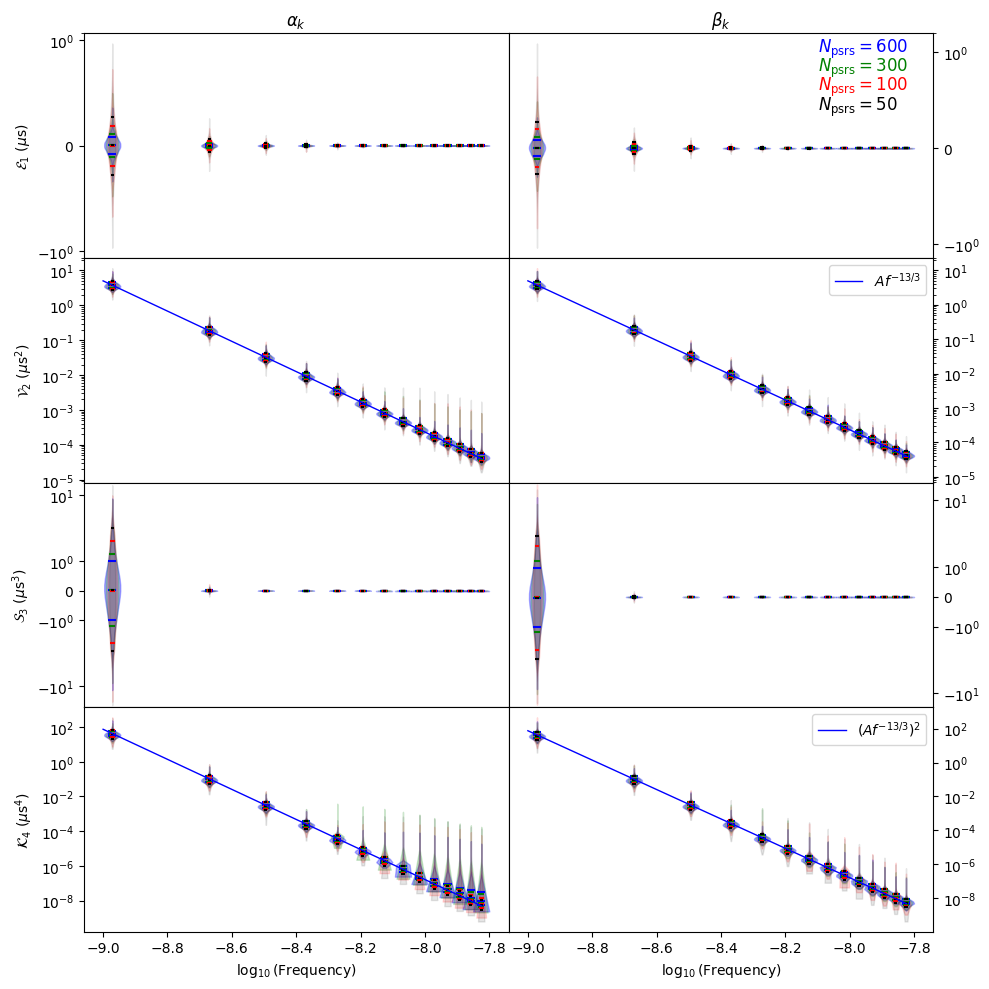

In [8]:
# violins
fig, ax=plt.subplots(nrows=4,ncols=2,sharex=True,figsize=(10,10))

plot_rk_moments(ax, opstats_npsrs600, color='blue', widths=0.05, alpha=0.3)
plot_rk_moments(ax, opstats_npsrs300, color='green', widths=0.04, alpha=0.2)
plot_rk_moments(ax, opstats_npsrs100, color='red', widths=0.03, alpha=0.15)
plot_rk_moments(ax, opstats_npsrs50, color='black', widths=0.02, alpha=0.1)

f_cont=np.linspace(1,15, 100)
logf_cont=np.log10(f_cont*1e-9)
gamma_gw=13/3; a_gw=5
pl_gw=lambda f: np.power(f,-gamma_gw)
ax[1,0].plot(logf_cont, a_gw*pl_gw(f_cont), 'b-', lw=1)
ax[1,1].plot(logf_cont, a_gw*pl_gw(f_cont), 'b-', lw=1, label=r'$A f^{-13/3}$')
ax[1,1].legend(loc='upper right')

ax[3,0].plot(logf_cont, 3*(a_gw*pl_gw(f_cont))**2, 'b-', lw=1)
ax[3,1].plot(logf_cont, 3*(a_gw*pl_gw(f_cont))**2, 'b-', lw=1, label=r'$(A f^{-13/3})^2$')
ax[3,1].legend(loc='upper right')

ax[0,1].text(-8.1, 1.0, r'$N_{\rm psrs}=600$', color='blue', fontsize=12)
ax[0,1].text(-8.1, 0.8, r'$N_{\rm psrs}=300$', color='green', fontsize=12)
ax[0,1].text(-8.1, 0.6, r'$N_{\rm psrs}=100$', color='red', fontsize=12)
ax[0,1].text(-8.1, 0.4, r'$N_{\rm psrs}=50$', color='black', fontsize=12)
    
ax[0,0].set_ylabel(r'${\cal E}_1$ ($\mu$s)')
ax[1,0].set_ylabel(r'${\cal V}_2$ ($\mu$s$^2$)')
ax[2,0].set_ylabel(r'${\cal S}_3$ ($\mu$s$^3$)')
ax[3,0].set_ylabel(r'${\cal K}_4$ ($\mu$s$^4$)')
ax[0,0].set_title(r'$\alpha_k$'); ax[0,1].set_title(r'$\beta_k$')
ax[len(ax)-1,0].set_xlabel(r'$\log_{10}$(Frequency)'); ax[len(ax)-1,1].set_xlabel(r'$\log_{10}$(Frequency)')

# ticks to right for the right column plots
for row in range(len(ax)):
    ax[row, 1].yaxis.tick_right()
    ax[row, 1].tick_params(labelright=True, labelleft=False)

ax[0,0].set_yscale('symlog'); ax[0,1].set_yscale('symlog')
ax[1,0].set_yscale('log'); ax[1,1].set_yscale('log')
ax[2,0].set_yscale('symlog'); ax[2,1].set_yscale('symlog')
ax[3,0].set_yscale('log'); ax[3,1].set_yscale('log')

ax[0,0].set_yticks([-1, 0, 1]); ax[0,1].set_yticks([-1, 0, 1])

fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)
plt.show()

Now for thr RN component, we import the pre-computed samples ...

(Note that the RN component is visually indistinguishable from the RN+GWB case because the RN completely dominates the one-point statistics of PTA.)

In [9]:
gwb_binary=0
rn_binary=1
opstats_npsrs50=load_ensemble_stats(npsrs=50, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs100=load_ensemble_stats(npsrs=100, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs300=load_ensemble_stats(npsrs=300, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)
opstats_npsrs600=load_ensemble_stats(npsrs=600, nsims=5000, gwb_binary=gwb_binary, rn_binary=rn_binary)

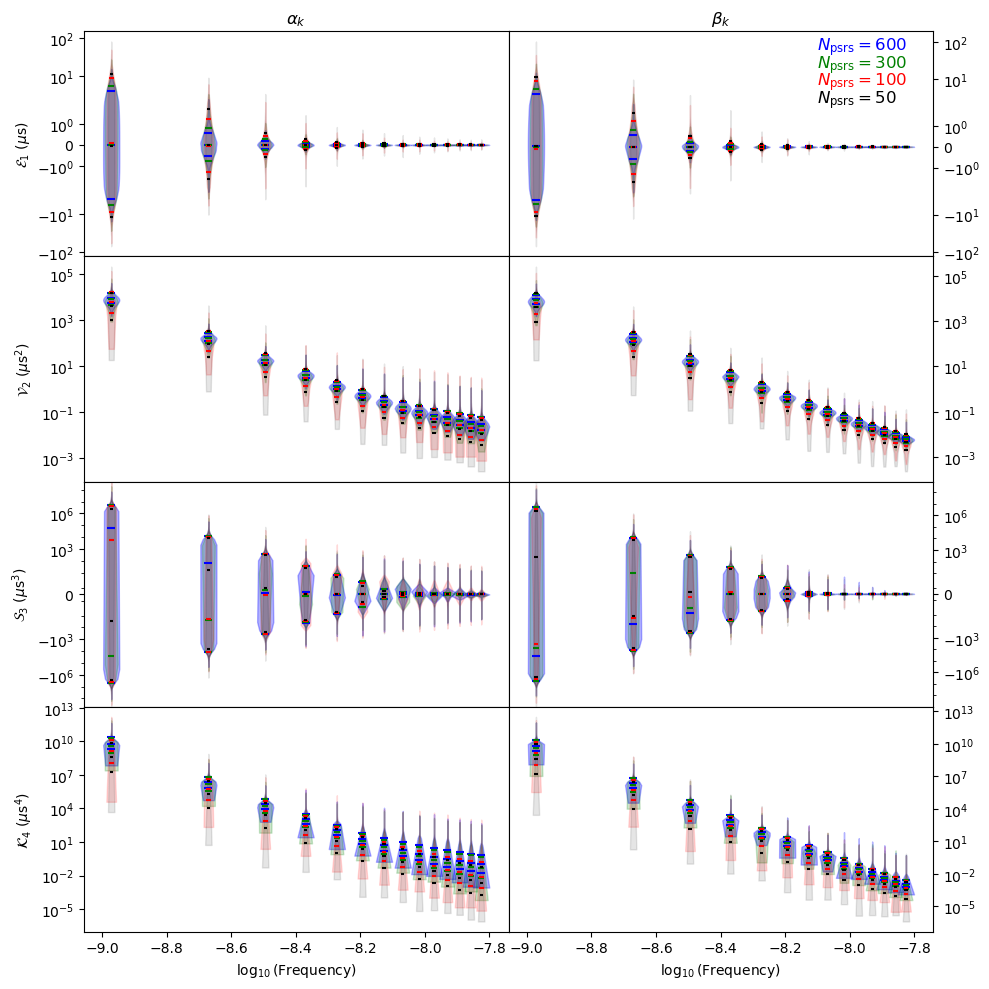

In [10]:
# violins
fig, ax=plt.subplots(nrows=4,ncols=2,sharex=True,figsize=(10,10))

plot_rk_moments(ax, opstats_npsrs600, color='blue', widths=0.05, alpha=0.3)
plot_rk_moments(ax, opstats_npsrs300, color='green', widths=0.04, alpha=0.2)
plot_rk_moments(ax, opstats_npsrs100, color='red', widths=0.03, alpha=0.15)
plot_rk_moments(ax, opstats_npsrs50, color='black', widths=0.02, alpha=0.1)

ax[0,1].text(-8.1, 60, r'$N_{\rm psrs}=600$', color='blue', fontsize=12)
ax[0,1].text(-8.1, 60/3, r'$N_{\rm psrs}=300$', color='green', fontsize=12)
ax[0,1].text(-8.1, 60/9, r'$N_{\rm psrs}=100$', color='red', fontsize=12)
ax[0,1].text(-8.1, 60/27, r'$N_{\rm psrs}=50$', color='black', fontsize=12)
    
ax[0,0].set_ylabel(r'${\cal E}_1$ ($\mu$s)')
ax[1,0].set_ylabel(r'${\cal V}_2$ ($\mu$s$^2$)')
ax[2,0].set_ylabel(r'${\cal S}_3$ ($\mu$s$^3$)')
ax[3,0].set_ylabel(r'${\cal K}_4$ ($\mu$s$^4$)')
ax[0,0].set_title(r'$\alpha_k$'); ax[0,1].set_title(r'$\beta_k$')
ax[len(ax)-1,0].set_xlabel(r'$\log_{10}$(Frequency)'); ax[len(ax)-1,1].set_xlabel(r'$\log_{10}$(Frequency)')

# ticks to right for the right column plots
for row in range(len(ax)):
    ax[row, 1].yaxis.tick_right()
    ax[row, 1].tick_params(labelright=True, labelleft=False)

ax[0,0].set_yscale('symlog'); ax[0,1].set_yscale('symlog')
ax[1,0].set_yscale('log'); ax[1,1].set_yscale('log')
ax[2,0].set_yscale('symlog'); ax[2,1].set_yscale('symlog')
ax[3,0].set_yscale('log'); ax[3,1].set_yscale('log')

ax[2,0].set_yticks([-1e6, -1e3, 0, 1e3, 1e6]); ax[2,1].set_yticks([-1e6, -1e3, 0, 1e3, 1e6])

fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)
plt.show()

#### End of notebook